In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# from jupyterthemes import jtplot
# jtplot.style()

In [2]:
import os
import gc
import cv2
import time
import itertools
import sklearn

import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns

from keras import backend as K
from matplotlib import pyplot as plt

from glob import glob
from tqdm import tqdm
from itertools import cycle
from tabulate import tabulate
from pandas import DataFrame
from keras import regularizers, optimizers, initializers

from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from keras.models import Sequential, Model
from keras.layers.core import Dense
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from keras_preprocessing.image import ImageDataGenerator

from keras.layers import (
    Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten, Dense, BatchNormalization, Activation
)
from sklearn.metrics import (
    roc_curve, auc, multilabel_confusion_matrix, ConfusionMatrixDisplay, classification_report, confusion_matrix
)
from tensorflow.keras.applications import (
    VGG16, VGG19, InceptionV3, Xception, DenseNet121, ResNet50V2, MobileNet, MobileNetV2, EfficientNetB0, EfficientNetB1, 
    EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7, 
    NASNetMobile, NASNetLarge
)

In [3]:
def calculate_cm(y_true, y_pred):
    fp = np.sum((y_pred == 1) & (y_true == 0))
    tp = np.sum((y_pred == 1) & (y_true == 1))
    fn = np.sum((y_pred == 0) & (y_true == 1))
    tn = np.sum((y_pred == 0) & (y_true == 0))
    return tp, fp, fn, tn

def calculate_recall(tp, fp, fn, tn):
    return (tp)/(tp + fn)

def calculate_fallout(tp, fp, fn, tn):
    return (fp)/(fp + tn)

def calculate_fpr_tpr(y_true, y_pred):
    tp, fp, fn, tn = calculate_cm(y_true, y_pred)
    tpr = calculate_recall(tp, fp, fn, tn)
    fpr = calculate_fallout(tp, fp, fn, tn)
    return fpr, tpr

In [4]:
def plot_class_samples(samples_count):
    labels = list(samples_count.keys())
    count = list(samples_count.values())
    
    plt.rcParams['figure.dpi'] = 150
    fig, ax = plt.subplots(figsize =(18, 8))
    ax.barh(labels, count)
    
    # Remove axes splines
    for s in ['top', 'bottom', 'left', 'right']:
        ax.spines[s].set_visible(False)
    
    # Remove x, y Ticks
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    
    # Add padding between axes and labels
    ax.xaxis.set_tick_params(pad = 2)
    ax.yaxis.set_tick_params(pad = 3)
    
    # Add x, y gridlines
    ax.grid(visible = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.2)
    
    # Show top values
    ax.invert_yaxis()
    
    # Add annotation to bars
    for i in ax.patches:
        plt.text(
            i.get_width() + 0.2, 
            i.get_y() + 0.5, 
            str(round((i.get_width()), 2)), 
            fontsize = 10, 
            fontweight = 'bold', 
            color ='grey'
        )
    
    ax.set_title('Samples Belonging to Each Class Label', loc ='center')
    plt.show()

In [5]:
# Data reading on Local Machine
image_paths = {os.path.basename(x): x for x in glob(os.path.join('.', 'images', '*.png'))}
df = pd.read_csv("./dataset_information/Data_Entry_2017.csv")

# Data reading on Kaggle
# image_paths = {os.path.basename(x): x for x in glob(os.path.join('..', 'input', 'data', 'images*', 'images', '*.png'))}
# df = pd.read_csv("/kaggle/input/data/Data_Entry_2017.csv")

df = df.drop(
    columns = [
        "Follow-up #", 
        "Patient ID", 
        "Patient Age", 
        "Patient Gender", 
        "OriginalImage[Width",
        "Height]",
        "OriginalImagePixelSpacing[x",
        "y]",
#         "Unnamed: 11",
        "View Position"
    ], 
    axis = 1
)

df["Image Paths"] = " "
for row_index in tqdm(range(len(df)), ncols = 100):
    img_name = df.iloc[row_index][0]
    path = image_paths[img_name]
    df["Image Paths"][row_index] = path

unique_labels = set(itertools.chain.from_iterable(df["Finding Labels"].apply(lambda x : x.split('|')).values)) 
one_hot_labels = pd.DataFrame(0.0, index = np.arange(len(df)), columns = unique_labels)

for index, row in df.iterrows():
    labels = row["Finding Labels"].split('|')
    for label in labels:
        one_hot_labels.iloc[index][label] = 1.0

df = pd.concat([df, one_hot_labels], axis = 1)
df = df.drop(columns = ["Finding Labels"], axis = 1)
# df.head(3)

100%|█████████████████████████████████████████████████████| 112120/112120 [01:23<00:00, 1340.85it/s]


In [6]:
# df_train, df_test = train_test_split(dataset_info.sample(n = 60000), test_size = 0.20, random_state = 142)
df_train, df_test = train_test_split(df, test_size = 0.20, random_state = 500)
df_train, df_val = train_test_split(df_train, test_size = 0.10, random_state = 0)

print(f"Training Samples: {len(df_train)}\nValidation Samples: {len(df_val)}\nTesting Samples: {len(df_test)}")

Training Samples: 80726
Validation Samples: 8970
Testing Samples: 22424


In [7]:
CLASS_LABELS = [
    "Atelectasis", "Cardiomegaly", "Consolidation", "Edema", "Effusion", "Emphysema", "Fibrosis", "Hernia", 
    "Infiltration", "Mass", "No Finding", "Nodule", "Pleural_Thickening", "Pneumonia","Pneumothorax"
]

USE_TRANSFER_LEARNING = True
IMAGE_SIZE = (400, 400,)
BATCH_SIZE = 4
EPOCHS = 20
LEARNING_RATE = 0.0001 if USE_TRANSFER_LEARNING else 0.01

BETA_FOR_BIASED_RECALL = 1.3
BETA_FOR_BIASED_PRECISION = 0.7
BETA_WITH_NO_BIAS = 1

THRESHOLDS = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [8]:
SAMPLES_PER_CLASS = dict()

for label in CLASS_LABELS:
    SAMPLES_PER_CLASS[label] = 0

for label in CLASS_LABELS:
    SAMPLES_PER_CLASS[label] = int(df[label].sum())
    
# plot_class_samples(SAMPLES_PER_CLASS)

In [9]:
SORTED_SAMPLES_PER_CLASS = dict(sorted(SAMPLES_PER_CLASS.items(), key=lambda x:x[1], reverse = True))
keys = list(SORTED_SAMPLES_PER_CLASS.keys())
values = list(SORTED_SAMPLES_PER_CLASS.values())

# sns.set(rc = {'figure.figsize' : (10, 4)})
# sns.barplot(x = values, y = keys, color = "green")

In [10]:
del(SORTED_SAMPLES_PER_CLASS["No Finding"])
keys = list(SORTED_SAMPLES_PER_CLASS.keys())
values = list(SORTED_SAMPLES_PER_CLASS.values())

# sns.barplot(x = values, y = keys, color = "green")

In [11]:
CLASS_WEIGHTS = dict()
label_with_most_samples = max(SAMPLES_PER_CLASS, key = SAMPLES_PER_CLASS.get)

for index, label in enumerate(CLASS_LABELS):
    CLASS_WEIGHTS[index] = SAMPLES_PER_CLASS[label_with_most_samples] / (len(CLASS_LABELS) * SAMPLES_PER_CLASS[label])

tabulated_weights_data = []    
for i in range(15):
    row = [CLASS_LABELS[i], SAMPLES_PER_CLASS[CLASS_LABELS[i]], CLASS_WEIGHTS[i]]
    tabulated_weights_data.append(row)
    
print(tabulate(tabulated_weights_data, headers = ["Class Name", "Samples", "Weightage"], tablefmt = "github", numalign = "left"))

| Class Name         | Samples   | Weightage   |
|--------------------|-----------|-------------|
| Atelectasis        | 11535     | 0.349152    |
| Cardiomegaly       | 2772      | 1.45291     |
| Consolidation      | 4667      | 0.862967    |
| Edema              | 2303      | 1.74879     |
| Effusion           | 13307     | 0.302658    |
| Emphysema          | 2516      | 1.60074     |
| Fibrosis           | 1686      | 2.38877     |
| Hernia             | 227       | 17.7421     |
| Infiltration       | 19870     | 0.202691    |
| Mass               | 5746      | 0.700917    |
| No Finding         | 60412     | 0.0666667   |
| Nodule             | 6323      | 0.636955    |
| Pleural_Thickening | 3385      | 1.1898      |
| Pneumonia          | 1353      | 2.97669     |
| Pneumothorax       | 5298      | 0.760186    |


In [12]:
def apply_sharpening(image):
    sharp_kernel = np.array(
        [
            [0, -1, 0], 
            [-1, 5, -1], 
            [0, -1, 0]
        ])
    output = cv2.filter2D(src = image, ddepth = -1, kernel = sharp_kernel)
    return output


def apply_min_max_scaling(image):
    image = (image - image.min()) / (image.max() - image.min())
    image = rescale(image, 0.25, multichannel = True, mode = "constant")
    return image

In [13]:
train_data_generator = ImageDataGenerator(
    rescale = 1. / 255,
    shear_range = 0.2,
    zoom_range = 0.05,
    width_shift_range = 0.05,
    height_shift_range = 0.05,
    fill_mode = "constant",
    preprocessing_function = apply_sharpening
)
val_data_generator = ImageDataGenerator(
    rescale = 1. / 255, 
    preprocessing_function = apply_sharpening
)
test_data_generator = ImageDataGenerator(
    rescale = 1. / 255, 
    preprocessing_function = apply_sharpening
)


def flow_from_dataframe(image_generator, dataframe):
    df_gen = image_generator.flow_from_dataframe(
        dataframe,
        x_col = "Image Paths", 
        y_col = dataframe.columns[2:],
        target_size = IMAGE_SIZE,
        color_mode = 'rgb',
        class_mode = 'raw',
        shuffle = False,
        batch_size = BATCH_SIZE
    )
    return df_gen


train_gen = flow_from_dataframe(image_generator = train_data_generator, dataframe = df_train)
valid_gen = flow_from_dataframe(image_generator = val_data_generator, dataframe = df_val)
test_gen = flow_from_dataframe(image_generator = test_data_generator, dataframe = df_test)

Found 80726 validated image filenames.
Found 8970 validated image filenames.
Found 22424 validated image filenames.


In [ ]:
# plt.rcParams["figure.figsize"] = (3,3)

# x = train_gen.next()
# # print(len(x[0][0]))

# for i in range(1):
#     for j in range(10):
#         image = x[i][j]
#         plt.imshow(image)
# #         plt.imshow((image * 255).astype(np.uint8))
#         plt.show()

In [ ]:
# t_x, t_y = next(train_gen)
# fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
# for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
#     c_ax.imshow(c_x[:,:,0])
#     c_ax.set_title(', '.join([n_class for n_class, n_score in zip(CLASS_LABELS, c_y) if n_score > 0.5]))
#     c_ax.axis('off')

# train_gen.reset()

In [17]:
class MultiLabelCrossEntropy:
    def __init__(self, labels: DataFrame, epsilon = 1e-7):
        self.epsilon = epsilon
        self.N = labels.shape[0]
        
        self.freq_pos = np.sum(labels == 1, axis=0)
        self.freq_neg = np.sum(labels == 0, axis=0)
        self.pos_weights = self.freq_neg  / self.N
        self.neg_weights = self.freq_pos  / self.N
        
        self.print_class_weights()
        
    def calculate_loss(self, true_y, pred_y):
        loss = 0.0
        for i in range(len(self.pos_weights)):
            loss += (-1 * K.mean(self.pos_weights[i] * true_y[:,i] * K.log(pred_y[:,i] + self.epsilon))) + (-1 * K.mean(self.neg_weights[i] * (1 - true_y[:,i]) * K.log(1 - pred_y[:,i] + self.epsilon)))
        
        return loss
        
    def contribution(self):
        return self.freq_pos * self.pos_weights, self.freq_neg * self.neg_weights
    
    def print_class_weights(self):
        tabulated_weights_data = []
        for i, l in zip(range(15), CLASS_LABELS):
            label_samples_percentage = (self.freq_pos[i] / SAMPLES_PER_CLASS[l]) * 100 
            row = [CLASS_LABELS[i], SAMPLES_PER_CLASS[l], self.freq_pos[i], label_samples_percentage, self.freq_neg[i], self.pos_weights[i], self.neg_weights[i]]
            tabulated_weights_data.append(row)
            
        print(tabulate(
            tabulated_weights_data, 
            headers = ["Class", "Total Samples", "Positive Samples [Train]",  "Sample Percentage [Train]","Negative Frequency [Train]", "Positive Weight", "Negative Weight"], 
            tablefmt = "github", 
            numalign = "left"
        ))

        
MLCE_Loss_With_Class_Weights = MultiLabelCrossEntropy(df_train[CLASS_LABELS])

| Class              | Total Samples   | Positive Samples [Train]   | Sample Percentage [Train]   | Negative Frequency [Train]   | Positive Weight   | Negative Weight   |
|--------------------|-----------------|----------------------------|-----------------------------|------------------------------|-------------------|-------------------|
| Atelectasis        | 11535           | 8368                       | 72.5444                     | 72358                        | 0.896341          | 0.103659          |
| Cardiomegaly       | 2772            | 1962                       | 70.7792                     | 78764                        | 0.975696          | 0.0243044         |
| Consolidation      | 4667            | 3350                       | 71.7806                     | 77376                        | 0.958502          | 0.0414984         |
| Edema              | 2303            | 1654                       | 71.8194                     | 79072                        | 0.979511      

In [18]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 4, verbose = 1, mode = 'auto', baseline = None, restore_best_weights = True)

METRICS = [
  tf.keras.metrics.TruePositives(name = 'tp'),
  tf.keras.metrics.FalsePositives(name = 'fp'),
  tf.keras.metrics.TrueNegatives(name = 'tn'),
  tf.keras.metrics.FalseNegatives(name = 'fn'), 
  tf.keras.metrics.BinaryAccuracy(name = 'binary_accuracy', threshold = 0.5),
  tf.keras.metrics.Precision(name = 'precision', thresholds = 0.3),
  tf.keras.metrics.Recall(name = 'recall', thresholds = 0.3),
  tf.keras.metrics.AUC(name = 'auc', multi_label = True, num_labels = 15, thresholds = THRESHOLDS),
  tf.keras.metrics.AUC(name = 'prc', curve = 'PR')
]

DEFINED_OPTIMIZERS = {
    "SGD" : tf.keras.optimizers.SGD(learning_rate = LEARNING_RATE, decay = 1e-6, momentum = 0.9, nesterov = True),
    "ADAM" : tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE, beta_1 = 0.9, beta_2 = 0.999,),
    "RMSPROP" : tf.keras.optimizers.RMSprop(learning_rate = LEARNING_RATE),
    "NADAM" : tf.keras.optimizers.Nadam(learning_rate = LEARNING_RATE,),
    "ADAMAX" : tf.keras.optimizers.Adamax(learning_rate = LEARNING_RATE,),
    "ADAGRAD" : tf.keras.optimizers.Adagrad(learning_rate = LEARNING_RATE,)
}

DEFINED_LOSSES = {
    "BCE" : "binary_crossentropy", 
    "MLBCE_CW" : MLCE_Loss_With_Class_Weights.calculate_loss
}

In [19]:
channels = (3,)
input_shape = IMAGE_SIZE + channels
img_input = Input(shape = input_shape)

MODEL_NAME = "MobileNet"
base_model = MobileNet(
    input_shape = input_shape,
    include_top = False,
    weights = "imagenet" if USE_TRANSFER_LEARNING else None
)

base_model.trainable = False

classifier = Sequential()
# classifier.add(Flatten())
classifier.add(GlobalAveragePooling2D(input_shape = base_model.output_shape[1:]))
classifier.add(Dropout(0.2))

classifier.add(Dense(256))
classifier.add(BatchNormalization())
classifier.add(Activation('relu'))
classifier.add(Dropout(0.2))

classifier.add(Dense(50))
classifier.add(BatchNormalization())
classifier.add(Activation('relu'))
classifier.add(Dropout(0.2))

classifier.add(Dense(15, activation = "sigmoid"))

model = Model(inputs = base_model.input, outputs = classifier(base_model.output))
# model.load_weights(f"./saved_weights/{MODEL_NAME}_{EPOCHS}_weights.h5")

model.compile(
    optimizer = DEFINED_OPTIMIZERS["ADAM"],
#     loss = DEFINED_LOSSES["MLBCE_CW"],
    loss = DEFINED_LOSSES["BCE"],
    metrics = METRICS,
)

USE_CLASS_WEIGHTS_IN_MODEL_FIT = False

In [20]:
start_time = time.time()

history = model.fit(
    epochs = EPOCHS,
    x = train_gen,
    validation_data = valid_gen,  
    steps_per_epoch = train_gen.n / train_gen.batch_size,
    validation_steps = valid_gen.n / valid_gen.batch_size,  
    shuffle = False,
    callbacks = None,
    verbose = 1,
    class_weight = CLASS_WEIGHTS if USE_CLASS_WEIGHTS_IN_MODEL_FIT else None,
)

print(f"\nTime Taken: {(time.time() - start_time) / 3600 : .4f} Hours")

Epoch 1/20


16646/20181 [=======================>......] - ETA: 12:05 - loss: 0.2486 - tp: 24928.0000 - fp: 30835.0000 - tn: 884172.0000 - fn: 58825.0000 - binary_accuracy: 0.9103 - precision: 0.3351 - recall: 0.4650 - auc: 0.5385 - prc: 0.3283

20181/20181 [==============================] - 4332s 214ms/step - loss: 0.2428 - tp: 30177.0000 - fp: 33715.0000 - tn: 1075414.0000 - fn: 71584.0000 - binary_accuracy: 0.9131 - precision: 0.3552 - recall: 0.4607 - auc: 0.5409 - prc: 0.3426 - val_loss: 0.2027 - val_tp: 3330.0000 - val_fp: 1476.0000 - val_tn: 121774.0000 - val_fn: 7970.0000 - val_binary_accuracy: 0.9298 - val_precision: 0.5558 - val_recall: 0.4281 - val_auc: 0.5878 - val_prc: 0.4884 26130.0000 - fp: 31485.0000 - tn: 928145.0000 - fn: 61720.0000 - binary_accu - ETA: 9:02 - loss: 0.2 - ETA: 7:12 - loss: 0.2461 - tp: 27055.0000 - fp: 31973.0000 - tn: 961306.0000 - fn: 63986.0000 - binary_accuracy: 0.9116 - precision: 0.3439 - recall: 0.4629 - auc: 0.5397 - prc: 0.334 - ETA: 7:12 - loss: 0.2461 - tp: - ETA: 6:40 - loss: 0.2458 - tp: 27286.0000 - fp: 32114.0000 - tn: 969691.0000 - fn: 64529.0000 - binary_accuracy: 0.9117 - precision: 0.3447 - recall: 0.4627 - auc: 0.5398  - ETA: 6:37 - loss: 0.2458 - tp: 27308.0000 - fp: 3212

 6838/20181 [=========>....................] - ETA: 45:04 - loss: 0.2069 - tp: 10454.0000 - fp: 5548.0000 - tn: 370238.0000 - fn: 23980.0000 - binary_accuracy: 0.9280 - precision: 0.5194 - recall: 0.4511 - auc: 0.5602 - prc: 0.4658A: 1:11:44 - loss: 0.2117 - tp: 366.0000 - fp: 196.0000 - tn: 12698.0000 - fn: 84 - ETA: 1:08:55 - loss: 0.2046 - tp: 925.0000 - fp: 498.0000 - tn: 31679.0000 - fn: 1998.0000 - binary_accuracy: 0.9289  - ETA: 1:08:44 - loss: 0.2039 - tp: 984.0000 - fp: 517.0000 - - ETA: 1:08:04 - loss: 0.2025 - tp: 1172.0000 - fp: 592.0000 - tn: 39496.0000 - fn: 2480.0000 - binary_accuracy:  - ETA: 1:07:40 - loss: 0.2022 - tp: 1283.0000 - fp: 658.0000 - tn: 43348.0000 - fn: 2711.0000 - binary_accuracy: 0.9298 - precision: 0.5281 - recall - ETA: 1:07:2 - ETA: 1:06:32 - loss: 0.2060 - tp: 1612.0000 - fp: 822.0000 - tn: 54515.0000 - fn: 3471.0000 - binary_accuracy: 0.9290 - precision: 0.5229 - recall: 0.4533 - au - ETA: 1:06:25 - loss: 0.2062 - tp: 1647.0000 - fp: 841.0000 - tn:

11045/20181 [===============>..............] - ETA: 30:46 - loss: 0.2071 - tp: 16679.0000 - fp: 8940.0000 - tn: 598165.0000 - fn: 38856.0000 - binary_accuracy: 0.9279 - precision: 0.5181 - recall: 0.4491 - auc: 0.5611 - prc: 0.4635- ETA: 44:53 - loss: 0.2070 - tp: 10534.0000 - fp: 5594 - ETA: 44:27 - loss: 0.2070 - tp: 10727.0000 - fp: 5693.0000 - tn: 380378.0000 - fn: 24642.0000 - binary_accuracy: 0.9280 - precision: 0.51 - ETA: 44:17 - loss: 0.2071 - tp: 10793.0000 - fp: 5735.0000 - tn: 382 - ETA: 43:53 - loss: 0.2071 - tp: 10960.0000 - fp:  - ETA: 43:25 - loss: 0.2072 - tp: 11158.0000 - fp: 5944.0000 - tn: 396493.0000 - fn: 25725.0000 - binary_accuracy: 0.9279 - precision: 0.5185 - recall: 0.4495 - auc: 0.5603  - ETA: 43:23 - loss: 0.2073 - tp: 11177.0000 - fp: 5958.0000 - tn: 397190.0000 - fn: 25775.0000 - binary_accuracy: 0.9279 - precision: 0.5184 - recall: 0.4 - ETA: 43:16 - loss: 0.2073 - tp: 11220.0000 - fp: 5986.0000 - tn: 398860.0000 - fn: 25894.0000 - binary_accuracy: 0.927

17836/20181 [=========================>....] - ETA: 7:53 - loss: 0.2075 - tp: 26845.0000 - fp: 14250.0000 - tn: 966021.0000 - fn: 62984.0000 - binary_accuracy: 0.9279 - precision: 0.5187 - recall: 0.4468 - auc: 0.5618 - prc: 0.4633  ETA: 30:22 - loss: 0.2069 - tp: 16879.0000 - fp: 9028.0000 - tn: 604524.0000 - fn: 39229.0000 - binary_accuracy: 0.9280 - precision: 0.5185 - recall: 0.4496 - auc: 0.5610  - ETA: 30:20 - loss: 0.2069 - tp: 16902.0000 - fp: 9039.0000 - tn: 605232.0000 - fn: 39267.0000 - binary_accuracy: 0.9280 - precision: 0.5185 - recall: 0 - ETA: 30:13 - loss: 0.2069 - tp: 16951.0000 - fp: 9065.0000 - tn: 607016.0000 - fn: 39388.0000 - binary_accuracy: 0.9280 - precision: 0.5186 - r - ETA: 30:05 - loss: 0.2070 - tp: 17013.0000 - fp: 9102.0000 - tn: 609228.0000 - fn: 39537.0000 - binary_accuracy: 0.9280 - precision: 0. - ETA: 29:55 - loss: 0.2070 - tp: 17095.0000 - fp: 9138.0000 - tn: 611885.0000 - fn: 39702.0000 - binary_accuracy: 0.9280 - precision: 0.5187 - recall: 0.449

20181/20181 [==============================] - 4265s 211ms/step - loss: 0.2076 - tp: 30379.0000 - fp: 16083.0000 - tn: 1093046.0000 - fn: 71382.0000 - binary_accuracy: 0.9278 - precision: 0.5190 - recall: 0.4461 - auc: 0.5622 - prc: 0.4636 - val_loss: 0.1968 - val_tp: 3560.0000 - val_fp: 1625.0000 - val_tn: 121625.0000 - val_fn: 7740.0000 - val_binary_accuracy: 0.9304 - val_precision: 0.5569 - val_recall: 0.4466 - val_auc: 0.5845 - val_prc: 0.5040- tn: 972039.0000 - fn: 63367.0000 - binary_accuracy: - ETA: 6:38 - loss: 0.2075 - tp: 27402.0000 - fp: 14552.0000 - tn: 986038.0000 - fn: 64308.0000 - binary_accuracy: 0.9279 - precision: 0.5185 - recall: 0.4466  - ETA: 6:33 - loss: 0.2075 - tp: 27441.0000 - fp: 14577.0000 - tn: 987505.0000 - fn: 64397.0000 - binary_accuracy: 0.9279 - precision: 0.5185 - recall: 0.4466 -  - ETA: 6:28 - loss: 0.2075 - tp: 27481.0000 - fp: 14595.0000 - tn: 988855.0000 - fn: 64489.0000 - binary_accuracy: 0.9279 - precision: 0.5185 - ETA: 6:19 - loss: 0.2076 - tp

 8908/20181 [============>.................] - ETA: 38:32 - loss: 0.2057 - tp: 13571.0000 - fp: 7266.0000 - tn: 482328.0000 - fn: 31255.0000 - binary_accuracy: 0.9279 - precision: 0.5213 - recall: 0.4517 - auc: 0.5642 - prc: 0.4668 TA: 1:08:22 - loss: 0.2042 - tp: 1452.0000 - fp: 764.0000 - tn: 50234.0000 - fn: 3230.0000 - binary_accuracy: 0.9283 - precision: 0.5316 - r - ETA: 1:08:09 - loss: 0.2042 - tp: 1517.0000 - fp: 796.0000 - tn: 52457.0000 - fn: 3370.0000 - binary_accuracy:  - ETA: 1:07:44 - loss: 0.2043 - tp: 1632.0000 - fp: 851.0000 - tn: 56295.0000 - fn: 3622.0000 - binary_accur - ETA: 1:07:20 - loss: 0 - ETA: 1:06:36 - loss: 0.2055 - tp: 1956.0000 - fp: 1016.0000 - tn: 6 - ETA: 1:06:19 - loss: 0.2060 - tp: 2047.0000 - fp: 1064.0000 - tn: 71092.0000 - fn: 4637 - ETA: 1:05:39 - loss: 0.2051 - tp: 2256. - ETA: 1:04:54 - loss: 0.2051 - tp: 2510.0000 - fp: 1329.0000 - tn: 87677.0000 - fn: 5684.0000 - binary_accuracy: 0.927 - ETA: 1:04:24 - loss: 0.2047 - tp: 2700.0000 - fp: 1431.

15470/20181 [=====================>........] - ETA: 16:03 - loss: 0.2060 - tp: 23397.0000 - fp: 12420.0000 - tn: 837887.0000 - fn: 54436.0000 - binary_accuracy: 0.9280 - precision: 0.5216 - recall: 0.4515 - auc: 0.5656 - prc: 0.4663 ETA: 38:19 - loss: 0.2058 - tp: 13655.0000 - fp: 7315.0000 - tn: 485627.0000 - fn: 31483.0000 - binary_accuracy: 0.9279 - precision: 0.5210 - recall: 0.4516 - auc: 0.5 - ETA: 38:16 - loss: 0.2058 - tp: 13682.0000 - fp: 7328.0000 - tn: 486546.0000 - fn: 31544.0000 - binary_accuracy: 0.9279 - precision: 0.5211 - recall: - ETA: 38:09 - loss: 0.2059  - ETA: 37:37 - loss: 0.2058 - tp: 13967.0000 - fp: 7458.0000 - tn: 497008.0000 - fn: 32247.0000 - binary_accuracy: 0.9279 - precis - ETA: 37:25 - loss: 0.2057 - tp: 1 - ETA: 36:54 - loss: 0.2056 - tp: 14292.0000 - fp: 7603.0000 - tn: 508266.0000 - fn: 32939.0000 - binary_accuracy: 0.9280 - precision: 0.5209 - - ETA: 36:45 - loss: 0 - ETA: 36:11 - loss: 0.2054 - tp: 14610.0000 - fp: 7756.0000 - tn: 519512.0000 - fn:

20181/20181 [==============================] - 4316s 214ms/step - loss: 0.2063 - tp: 30417.0000 - fp: 16000.0000 - tn: 1093129.0000 - fn: 71344.0000 - binary_accuracy: 0.9279 - precision: 0.5219 - recall: 0.4505 - auc: 0.5663 - prc: 0.4669 - val_loss: 0.1967 - val_tp: 3472.0000 - val_fp: 1540.0000 - val_tn: 121710.0000 - val_fn: 7828.0000 - val_binary_accuracy: 0.9304 - val_precision: 0.5564 - val_recall: 0.4566 - val_auc: 0.5813 - val_prc: 0.5056loss: 0.2060 - tp: 26056.0000 - - ETA: 9:23 - loss: 0.2060 - tp: 26265.0000 - fp: 13871.0000 - tn: 943993.0000 - fn: 61431.0000 - binary_accuracy: 0.9281 - precision: 0.5208  - ETA: 9:14 - loss: 0.2060 - tp: 26332.0000 - fp: 13903.0000 - tn: 946388.0000 - fn: 61577.0000 - binary_acc - ETA: 8:58 - loss: 0.2060 - tp: 26458.0000 - fp: 13966.0000 - tn: 950596.0000 - fn: 61860.0000 - binary_accuracy: 0.9281 - precision: 0.5209 - rec - ETA: 8:50 - loss: 0.2060 - tp: 26525.0000 - fp: 13994.0000 - tn: 952717.0000 - fn: 61984.0000 - binary_accuracy: 0.

 4683/20181 [=====>........................] - ETA: 52:49 - loss: 0.2043 - tp: 7264.0000 - fp: 3809.0000 - tn: 253511.0000 - fn: 16336.0000 - binary_accuracy: 0.9283 - precision: 0.5296 - recall: 0.4590 - auc: 0.5689 - prc: 0.4732 2:23 - loss: 0.214 - ETA: 1:14:21 - loss: 0.2122 - tp: 183.0000 - fp: 98.0000 - tn: 6539. - ETA: 1:13:09 - loss: 0.2092 - tp: 272.0000 - fp: 151.0000 - tn: 9617.0000 - fn: 640.0000 - bina - ETA: 1:12:01 - loss: 0.2075 - tp: 391.0000 - fp: 197.0000 - tn: 13750.0000 - fn: 902.0000 - binary_accuracy: 0.9279 - precision: 0.5415 - ETA: 1:11:35 - loss: 0.2057 - tp: 455.0000 - fp: 222.0000 - tn: 15755.0000 - fn: 1028.0000 - binary_accuracy: 0.9284 - pr - ETA: 1:10:29 - loss: 0.2029 - tp: 648.0000 - fp: 326.0000 - tn: 22375.0000 - fn: 1431.0000 - binary_accuracy: 0.9291 - precision: 0.5376  - ETA: 1:10:19 - loss: 0.2031 - tp: 680.0000 - fp: 348.0000 - tn: 23565.0000 - fn: 1507.0000 - binary_accuracy: 0.9289 - precision: 0.5368 - recall: 0.4572 - auc: 0.5698 - prc:  -

10059/20181 [=============>................] - ETA: 34:20 - loss: 0.2042 - tp: 15370.0000 - fp: 7997.0000 - tn: 544819.0000 - fn: 35234.0000 - binary_accuracy: 0.9284 - precision: 0.5242 - recall: 0.4553 - auc: 0.5711 - prc: 0.4719ETA: 49:59 - loss: 0.2045 - tp: 8530.0000 - fp: 4457.0000 - tn: 297623.0000 - ETA: 49:47 -  - ETA: 49:30 - loss: 0.2043 - tp: 8749.0000 - fp: 4562.0000 - tn: 305170.0000 - fn: 19679.0000 - binary_accuracy: 0.9283 - precision: 0.5282 - recall: 0.45 - ETA: 49:26 - loss:  - ETA: 48:50 - loss: 0.2040 - tp: 9049.0000 - fp: 4717.0000 - tn: 315484.0000 - f - ETA: 48:01 - loss: 0.2039 - tp: 9426.0000 - fp: 4910.0000 - tn: 328387.0000 - fn: 21117.0000 - binary_accuracy: 0.9285 - precision: 0.5272 - recall:  - ETA: 47:58 -  - ETA: 47:40 - loss: 0.2039 - tp: 9576.0000 - fp: 4989.0000 - tn: 333918.0000 - fn: 21477.0000 - binary_accuracy: 0.9285 - precision: 0.527 - ETA: 47:15 - loss: 0.2037 - tp: 9754.0000 - fp: 5071.0000 - tn: 340234.0000 - fn: 21861.0000 - binary_accur

14132/20181 [====================>.........] - ETA: 20:29 - loss: 0.2041 - tp: 21585.0000 - fp: 11260.0000 - tn: 765550.0000 - fn: 49465.0000 - binary_accuracy: 0.9284 - precision: 0.5257 - recall: 0.4542 - auc: 0.5713 - prc: 0.4724 ETA: 33:59 - loss: 0.2040 - tp: 15526.0000 - fp: 8070.0 - ETA: 33:33 - loss: 0.2040 - tp: 15715.0000 - fp: 8176.0000 - tn: 557366.0000 - fn: 36023.0000 - binary_accuracy: 0.9284 - precision: 0.5244 - recall: 0.4558 - auc: 0.5712 - prc: 0.47 - ETA: 33:32 - loss: 0.2040 - tp: 15717.0000 - fp: 8178.0000 - tn: 557474.0000 - fn: 36031.0000 - binary_accuracy: 0.9284 - precision: 0.5244 - recall: 0.4558 - auc: 0.5 - ETA: 33:29 - loss: 0.2040 - tp: 15738.0000 - fp: 8196.0000 - tn: 558386.000 - ETA: 33:07 - loss: 0.2040 - tp: 15901.0000 - fp: 8277.000 - ETA: 32:40 - loss: 0.2041 - tp: 16076.0000 - fp: 8384.0000 - tn: 571161.0000 - fn: 36959.0000 - binary_accuracy: 0. - ETA: 32:26 - loss: 0.2042 - tp: 16175.0000 - fp: 8438.0000 - tn: 574876.0000 - fn: 37231.0000 - bi

20181/20181 [==============================] - 4290s 213ms/step - loss: 0.2048 - tp: 30615.0000 - fp: 15856.0000 - tn: 1093273.0000 - fn: 71146.0000 - binary_accuracy: 0.9282 - precision: 0.5241 - recall: 0.4514 - auc: 0.5722 - prc: 0.4717 - val_loss: 0.1952 - val_tp: 3471.0000 - val_fp: 1522.0000 - val_tn: 121728.0000 - val_fn: 7829.0000 - val_binary_accuracy: 0.9305 - val_precision: 0.5439 - val_recall: 0.4802 - val_auc: 0.5922 - val_prc: 0.5100 - loss: 0.2043 - tp: 23923.0000 - fp: 12468.0000 - tn: 851767.0000 - fn: 55162.0000 - binary_accuracy: 0.9284 - precision: 0.5246 - reca - ETA: 15:01 - loss: 0.2043 - tp: 23946.0000 - fp: 12484.0000 - tn: 852797.0000 - fn: 55233.0000 - binary_accuracy: 0.9 - ETA: 10:27 - loss: 0.2045 - tp: 25920.0000 - fp: 13500.0000 - tn: 925951.0000 - fn: - ETA: 10:17 - loss: 0.2045 - tp: 25998.0000 - fp: 13539.0000 - tn: 928710.0000 - fn: 60273.00 - ETA: 9:36 - loss: 0.2045 - tp: 26318.0000 - fp: - ETA: 9:09 - loss: 0.2044 - tp: 26522.0000 - fp: 13777.0000

20181/20181 [==============================] - 4397s 218ms/step - loss: 0.2040 - tp: 30457.0000 - fp: 15658.0000 - tn: 1093471.0000 - fn: 71304.0000 - binary_accuracy: 0.9282 - precision: 0.5250 - recall: 0.4528 - auc: 0.5744 - prc: 0.4745 - val_loss: 0.1945 - val_tp: 3530.0000 - val_fp: 1562.0000 - val_tn: 121688.0000 - val_fn: 7770.0000 - val_binary_accuracy: 0.9306 - val_precision: 0.5467 - val_recall: 0.4737 - val_auc: 0.5952 - val_prc: 0.5117  - ETA: 46:58 - loss: 0.2030 - tp: 10374.0000 - fp: 5 - ETA: 46:29 - loss: 0.2030 - tp: 10573.0000 - fp: 5522.0000 - tn: 373567.0000 - fn: 24158.0000 - binary_accuracy: 0.9283 - precision: 0.5267 - recall: - ETA: 46:21 - loss: 0.2030 - tp: 10633.0000 - fp: 5546.0000 - tn: 375469.0000 - fn: 24272.0000 - binary_accuracy: 0.9283 - precision: 0.5269 - ETA: 46:12 - loss: 0.2031 - tp: 10698.0000 - fp: 5580.0000 - tn: 377909.0000 - fn: 24433.0000 - binary_accuracy: 0.9283 - precision: 0.5267 - recall: 0.4598 - auc: 0.5724  - ETA: 46:09 - loss: 0.203

20181/20181 [==============================] - 4383s 217ms/step - loss: 0.2039 - tp: 30448.0000 - fp: 15539.0000 - tn: 1093590.0000 - fn: 71313.0000 - binary_accuracy: 0.9283 - precision: 0.5264 - recall: 0.4541 - auc: 0.5765 - prc: 0.4743 - val_loss: 0.1943 - val_tp: 3513.0000 - val_fp: 1563.0000 - val_tn: 121687.0000 - val_fn: 7787.0000 - val_binary_accuracy: 0.9305 - val_precision: 0.5432 - val_recall: 0.4794 - val_auc: 0.5945 - val_prc: 0.51165074.0000 - tn: 3 - ETA: 47:33 - loss: 0.2025 - tp: 10024.0000 - fp: 5132.0000 - tn: 351434.0000 - fn: 22630.0000 - binary_accuracy: 0.9287 - precision: 0.5295  - ETA: 47:24 - loss: 0.2024 - tp: 10092.0000 - fp: 5164.0000 - tn: 353830.0000 - fn: 22774.0000 - binary_accuracy: 0.9287 - precision: 0.5299 - recall: 0.4608 - a - ETA: 47:19 - loss: 0.2024 - tp: 10128.0000 - fp: 5183.0000 - tn: 355122.0000 - fn: 22867.0000 - binary_accuracy: 0.9287 - precision: 0.5298 - recall: 0.4606 - auc: 0.5751 - prc: 0. - ETA: 47:18 - loss: 0.2024 - tp: 10135.00

20181/20181 [==============================] - 5372s 266ms/step - loss: 0.2035 - tp: 30563.0000 - fp: 15682.0000 - tn: 1093447.0000 - fn: 71198.0000 - binary_accuracy: 0.9283 - precision: 0.5244 - recall: 0.4559 - auc: 0.5777 - prc: 0.4756 - val_loss: 0.1939 - val_tp: 3519.0000 - val_fp: 1554.0000 - val_tn: 121696.0000 - val_fn: 7781.0000 - val_binary_accuracy: 0.9306 - val_precision: 0.5451 - val_recall: 0.4833 - val_auc: 0.5974 - val_prc: 0.5136360.0000 - fp: 14076.0000 - tn: 979754.0000 - fn: 63730.0000 - binary_accuracy: 0.9284 - precision: 0.5240 - recall:  - ETA: 8:51 - loss: 0.2034 - tp: 27420.0000 - fp: 14098.0000 - tn: 981606.0000 - fn: 63836.0000 - binary_accuracy: 0.9284 - precision: 0.5240 - recall: 0.4562 - ETA: 8:43 - loss: 0.2034 - tp: 27456.0000 - fp: 14125.0000 - tn: 983119.0000 - fn: 63940.0000 - binary_accuracy: 0.9284 - precision: 0.5240 - recall: 0.4562 - auc: 0.5774 - prc: 0.4 - ETA: 8:42 - loss: 0.2034 - tp: 27460.0000 - fp: 14127.0000 - tn: 983283.0000 - fn: 639

20181/20181 [==============================] - 5664s 281ms/step - loss: 0.2019 - tp: 30602.0000 - fp: 15461.0000 - tn: 1093668.0000 - fn: 71159.0000 - binary_accuracy: 0.9285 - precision: 0.5268 - recall: 0.4595 - auc: 0.5837 - prc: 0.4802 - val_loss: 0.1931 - val_tp: 3562.0000 - val_fp: 1552.0000 - val_tn: 121698.0000 - val_fn: 7738.0000 - val_binary_accuracy: 0.9310 - val_precision: 0.5355 - val_recall: 0.4979 - val_auc: 0.6065 - val_prc: 0.5164uracy: 0.9285 - precision: 0.5268 - recall: 0.4596 - ETA: 4s - loss: 0.2019 - tp: 30574.0000 - fp: 15447.0000 - tn: 1092668.0000 - fn: 71091.0000 - binary_accuracy: 0.9285 - precision: 0.5268 - re
Epoch 15/20
20181/20181 [==============================] - 4951s 245ms/step - loss: 0.2017 - tp: 30581.0000 - fp: 15413.0000 - tn: 1093716.0000 - fn: 71180.0000 - binary_accuracy: 0.9285 - precision: 0.5265 - recall: 0.4601 - auc: 0.5845 - prc: 0.4809 - val_loss: 0.1930 - val_tp: 3572.0000 - val_fp: 1572.0000 - val_tn: 121678.0000 - val_fn: 7728.0000

20181/20181 [==============================] - 4547s 225ms/step - loss: 0.2019 - tp: 30401.0000 - fp: 15375.0000 - tn: 1093754.0000 - fn: 71360.0000 - binary_accuracy: 0.9284 - precision: 0.5264 - recall: 0.4601 - auc: 0.5839 - prc: 0.4799 - val_loss: 0.1933 - val_tp: 3420.0000 - val_fp: 1443.0000 - val_tn: 121807.0000 - val_fn: 7880.0000 - val_binary_accuracy: 0.9307 - val_precision: 0.5371 - val_recall: 0.4964 - val_auc: 0.6076 - val_prc: 0.5162- ETA: 1:07:48 - loss: 0.2006 - tp: 3170.0000 - fp: 1618.0000 - tn: 112007.0000 - fn: 7285.0000 - binary_accuracy: 0.9282 - precision: 0.5344 - recall:  - ETA: 1:07:36 - loss: 0.2007 - tp: 3227.0000 - fp: 1642.0000 - tn: 11 - ETA: 1:03:02 - loss: 0.2014 - t - ETA: 54:31 - loss: 0.2012 - tp: 8048.0000 - fp: 4096.0000 - tn: 282811.0000 - fn: 18305.0000 - binary_accuracy: 0.9285 - precision: 0.5304 - recall: 0.4672 - ETA: 54:27 - loss: 0.2012 - tp:  - ETA: 48:04 - loss: 0.2006 - tp: 10623.0000 - fp: 5375.0000 - tn: 374868.0000 - fn - ETA: 47:41 -

20181/20181 [==============================] - 4493s 223ms/step - loss: 0.2016 - tp: 30608.0000 - fp: 15572.0000 - tn: 1093557.0000 - fn: 71153.0000 - binary_accuracy: 0.9284 - precision: 0.5269 - recall: 0.4608 - auc: 0.5853 - prc: 0.4810 - val_loss: 0.1930 - val_tp: 3575.0000 - val_fp: 1575.0000 - val_tn: 121675.0000 - val_fn: 7725.0000 - val_binary_accuracy: 0.9309 - val_precision: 0.5355 - val_recall: 0.4966 - val_auc: 0.6025 - val_prc: 0.5168- fn: 2352.00 - ETA: 1:08:56 - loss: 0.1954 - tp: 1240 - ETA: 1:08:07 - loss: 0.1989 - tp: 1466.0000 - fp: 748.00 - ETA: 1:04:01 - loss: 0.1999 - tp: 3032.0000 - fp: 1531.0000 - tn: 105671.0000 - fn: 6826.0000 - binary_accuracy: 0.9286 - precisi - ETA: 1:03:50 - loss: 0.2004 - tp: 3113.0000 - fp: 1577.0000 - tn: 108642.0000 - fn: 7028.0000 - binary_accuracy: 0.9285 - precision: 0.5345 - recall: - ETA: 1:03:43 - loss: 0.2003 - tp: 3167.0000 - fp: 1607.0000 - tn: 110537.0000 - fn: 7149.0000 - binary_accuracy: 0.9285 - precision: 0.53 - ETA: 1:03

20181/20181 [==============================] - 4802s 238ms/step - loss: 0.2014 - tp: 30556.0000 - fp: 15445.0000 - tn: 1093684.0000 - fn: 71205.0000 - binary_accuracy: 0.9285 - precision: 0.5262 - recall: 0.4607 - auc: 0.5863 - prc: 0.4812 - val_loss: 0.1928 - val_tp: 3537.0000 - val_fp: 1526.0000 - val_tn: 121724.0000 - val_fn: 7763.0000 - val_binary_accuracy: 0.9310 - val_precision: 0.5321 - val_recall: 0.4996 - val_auc: 0.6078 - val_prc: 0.5169ry_accura - ETA: 45:01 - loss: 0.2009 - tp: 11385.0000 - fp: 5800.0000 - tn: 401734.0000 - fn: 25981.0000 - binary_accuracy: 0.9286  - ETA: 44:48 - loss: 0.2009 - tp: 11482.0000 - fp: 5844.0000 - tn: 405208.0000 - fn: 26206.0000 - binary_accuracy - ETA: 44:33 - loss: 0.2008 - tp: 11591.0000 - fp: 5894.0000 - tn: 409189.0000 - fn: 26446.0000 - binary_accuracy: 0.9286 - precision: 0.5258 - recall: 0 - ETA: 44:26 - loss: 0.2009 - tp: 11637.0000 - fp: 5924.0000 - tn: 410966.0000 - fn: 26573.0000 - binary_accuracy: 0. - ETA: 44:11 - loss: 0.2009 - 

20181/20181 [==============================] - 5554s 275ms/step - loss: 0.2012 - tp: 30556.0000 - fp: 15344.0000 - tn: 1093785.0000 - fn: 71205.0000 - binary_accuracy: 0.9286 - precision: 0.5272 - recall: 0.4620 - auc: 0.5870 - prc: 0.4826 - val_loss: 0.1928 - val_tp: 3527.0000 - val_fp: 1516.0000 - val_tn: 121734.0000 - val_fn: 7773.0000 - val_binary_accuracy: 0.9310 - val_precision: 0.5321 - val_recall: 0.4972 - val_auc: 0.6086 - val_prc: 0.51690000 - fp: 7136.0000 - tn: 498712.0000 - fn: 32303.0000 - binary_accuracy: 0.9286 - precision: - ETA: 56:27 - loss: 0.2006 - tp: 14110.0000 - fp: 7167.00 - ETA: 55:34 - loss: 0.2006 - tp: 14310.0000 - fp: 7253.0000 - tn: 508505.0000 - fn: 32912.0000 - binary_accuracy: 0.9287 - precision: 0.5260 - recall: 0.4651 - auc: 0.5875 - prc: - ETA: 55:31 - loss: 0.2006 - tp: 14319.0000 - fp: 7261.0000 - tn: 508885.0000 - fn: 32935.0000 - binary_accuracy: 0.9287 - precision: 0.5260 - recall:  - ETA: 55:17 - loss: 0.2005 - tp: 14382.0000 - fp: 7274.0000 -

 7195/20181 [=========>....................] - ETA: 48:03 - loss: 0.2000 - tp: 11058.0000 - fp: 5549.0000 - tn: 389840.0000 - fn: 25193.0000 - binary_accuracy: 0.9288 - precision: 0.5275 - recall: 0.4661 - auc: 0.5874 - prc: 0.4868 : 1:28:24 - loss: 0.1974 - tp: 778.0000 - fp: 392.0000 - tn: 26274.0000 - fn: 1656.0000 - binary_accuracy: 0.9296 - precision: 0.5415 - recall: 0.4688 - auc:  - ETA: 1:27:58 - loss: 0.1971 - tp: 794.0000 - fp: 399.0000 - tn: 26820.0000 - fn: 1687.0000 - binary_accuracy: 0.9298 - precision: 0.540 - ETA: 1:27:08 - loss: 0.1971 - tp: 829.0000 - fp: 420.0000 - tn: 28067 - ETA: 1:21:55 - loss: 0.1944 - tp: 11 - ETA: 1:19:25 -  - ETA: 1:17:12 - loss: 0.1985 - tp: 1642.0000 - fp: 779.0000 - tn: 55482.0000 - fn: 3537.0000 - binary_accuracy: 0.9298 - precis - ETA: 1:16:35 - loss: 0.1995 - tp: 1722.0000 - fp: 830.0000 - tn: 58492.0000 - fn: 3756.0000 - binary_accuracy: 0.9292 - precision: 0.5338 - recall: 0.4631 - auc: 0.5 - ETA: 1:16:25 - loss: 0.1995 - tp: 1745.0000

20181/20181 [==============================] - 5030s 249ms/step - loss: 0.2011 - tp: 30514.0000 - fp: 15335.0000 - tn: 1093794.0000 - fn: 71247.0000 - binary_accuracy: 0.9286 - precision: 0.5254 - recall: 0.4607 - auc: 0.5870 - prc: 0.4826 - val_loss: 0.1925 - val_tp: 3538.0000 - val_fp: 1520.0000 - val_tn: 121730.0000 - val_fn: 7762.0000 - val_binary_accuracy: 0.9310 - val_precision: 0.5322 - val_recall: 0.5023 - val_auc: 0.6114 - val_prc: 0.5180

Time Taken:  27.5875 Hours


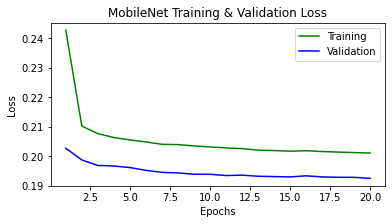

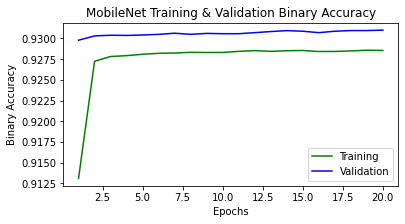

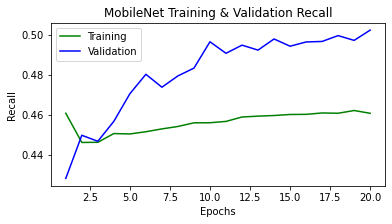

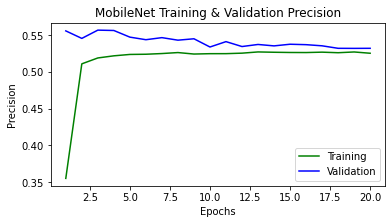

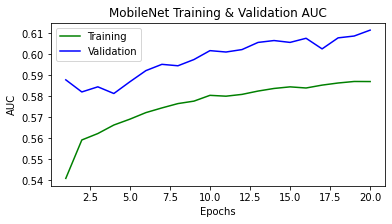

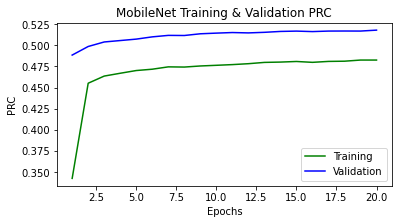

In [21]:
plt.figure(1, figsize = (6,3))
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['loss'], 'g', label = 'Training')
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['val_loss'], 'b', label = 'Validation')
plt.title(f'{MODEL_NAME} Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(2, figsize = (6,3))
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['binary_accuracy'], 'g', label = 'Training')
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['val_binary_accuracy'], 'b', label = 'Validation')
plt.title(f'{MODEL_NAME} Training & Validation Binary Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Binary Accuracy')
plt.legend()
plt.show()

plt.figure(3, figsize = (6,3))
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['recall'], 'g', label = 'Training')
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['val_recall'], 'b', label = 'Validation')
plt.title(f'{MODEL_NAME} Training & Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

plt.figure(4, figsize = (6,3))
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['precision'], 'g', label = 'Training')
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['val_precision'], 'b', label = 'Validation')
plt.title(f'{MODEL_NAME} Training & Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show()

plt.figure(6, figsize = (6,3))
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['auc'], 'g', label = 'Training')
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['val_auc'], 'b', label = 'Validation')
plt.title(f'{MODEL_NAME} Training & Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.show()

plt.figure(7, figsize = (6,3))
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['prc'], 'g', label = 'Training')
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['val_prc'], 'b', label = 'Validation')
plt.title(f'{MODEL_NAME} Training & Validation PRC')
plt.xlabel('Epochs')
plt.ylabel('PRC')
plt.legend()
plt.show()

In [22]:
# model.save_weights(f"./saved_weights_MLBCE/{MODEL_NAME}_{EPOCHS}_weights.h5")
evaluation = model.evaluate(test_gen)

5606/5606 [==============================] - 641s 114ms/step - loss: 0.1938 - tp: 8739.0000 - fp: 3681.0000 - tn: 304340.0000 - fn: 19600.0000 - binary_accuracy: 0.9308 - precision: 0.5236 - recall: 0.4981 - auc: 0.6109 - prc: 0.5175loss: 0.2127 - tp: 54.0000 - fp: 28.0000 - tn: 2107.0000 - fn: 151.0000 - binary_accuracy: 0.9235 - precision: 0.4845 - recall - ETA: 8:11 - loss: 0.2036 - tp: 106.0000 - fp: 52.0000 - tn: 390 - ETA: 8:10 - loss: 0.1991 - tp: 202.0000 - fp: 88.0000 - tn: 6925.0000 - fn: 465.0000 - binary_accuracy: 0.9280 - precision: 0.5369 - recall: 0.4903 - auc: 0.6122 - - ETA: 8:11 - loss: 0.1973 - tp: 2 - ETA: 8:02 - loss: 0.2001 - tp: 356.0000 - fp: 154.0000 - tn: 12020.0000 - fn: 790.0000 - binary - ETA: 7:59 - loss: 0.2007 - tp: 416.0000 - fp: 178.0000  - ETA: 7:37 - loss: 0.1980 - tp: 852.0000 - fp: 367.0000 - tn: 29961.0000 - fn: 2000.0000 - binary_accuracy - ETA: 6:59 - loss: 0.1957 - tp: 1586.0000 - fp: 655.0000 - tn: 54275 - ETA: 6:52 - l - ETA: 6:44 - los - ETA

In [23]:
test_loss = evaluation[0]
TP = evaluation[1]
FP = evaluation[2]
TN = evaluation[3]
FN = evaluation[4]
binary_accuracy = evaluation[5] * 100
auc = evaluation[8] * 100
auc_pr = evaluation[9] * 100

specificity = (TN / (TN + FP)) * 100
recall = (TP / (TP + FN)) * 100
precision = (TP / (TP + FP)) * 100
f1_score = (2 * recall * precision) / (recall + precision)

print(f"Testing Loss: \t\t{test_loss}\n")
print(f"True Positives: \t{TP}\nFalse Positives: \t{FP}\nTrue Negatives: \t{TN}\nFalse Negatives: \t{FN}\n")
print(f"Binary Accuracy: \t{binary_accuracy}")
print(f"Average Recall: \t{recall}\nAverage Precision: \t{precision}\nF1-Score: \t\t{f1_score}\nAverage Specificity: \t{specificity}\n")
print(f"AUC: \t\t\t{auc}\nAUC-PR: \t\t{auc_pr}")

Testing Loss: 		0.1937580555677414

True Positives: 	8739.0
False Positives: 	3681.0
True Negatives: 	304340.0
False Negatives: 	19600.0

Binary Accuracy: 	93.07745099067688
Average Recall: 	30.837361939376827
Average Precision: 	70.3623188405797
F1-Score: 		42.88132682352364
Average Specificity: 	98.80495161044215

AUC: 			61.09123229980469
AUC-PR: 		51.74682140350342


In [24]:
test_gen.reset()
predictions = model.predict(test_gen)

In [25]:
def binary_accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.round(y_pred)))

def precision_threshold(threshold = 0.5):
    def precision(y_true, y_pred):
        threshold_value = threshold
        y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), threshold_value), K.floatx())
        true_positives = K.round(K.sum(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(y_pred)
        precision_ratio = true_positives / (predicted_positives + K.epsilon())
        return precision_ratio
    return precision

def recall_threshold(threshold = 0.5):
    def recall(y_true, y_pred):
        threshold_value = threshold
        y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), threshold_value), K.floatx())
        true_positives = K.round(K.sum(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.clip(y_true, 0, 1))
        recall_ratio = true_positives / (possible_positives + K.epsilon())
        return recall_ratio
    return recall

def fbeta_score_threshold(beta = 1, threshold = 0.5):
    def fbeta_score(y_true, y_pred):
        threshold_value = threshold
        beta_value = beta
        p = precision_threshold(threshold_value)(y_true, y_pred)
        r = recall_threshold(threshold_value)(y_true, y_pred)
        bb = beta_value ** 2
        fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
        return fbeta_score
    return fbeta_score
    
def print_results(beta, threshold, test_labels, prediction):
    accuracy = K.eval(binary_accuracy(K.variable(value = test_labels), K.variable(value = prediction)))
    precision = K.eval(precision_threshold(threshold = threshold)(K.variable(value = test_labels), K.variable(value = prediction)))
    recall = K.eval(recall_threshold(threshold = threshold)(K.variable(value = test_labels), K.variable(value = prediction)))
    f1_score = K.eval(fbeta_score_threshold(beta = beta, threshold = threshold)(K.variable(value = test_labels), K.variable(value = prediction)))
    print(f"BETA: {beta}, THRESHOLD: {threshold}")
    print (f"Binary Accuracy: \t{accuracy * 100} % \nRecall: \t\t{recall * 100} % \nPrecision: \t\t{precision * 100} % \nF1-Score: \t\t{f1_score * 100} %\n")

In [26]:
test_labels = []
for label in test_gen.labels:
    test_labels.append(label)

# # Results with F Score giving more weightage to Recall
# for threshold in THRESHOLDS:
#     print_results(beta = BETA_FOR_BIASED_RECALL, threshold = threshold, test_labels = test_labels, prediction = predictions)

# # Results with F Score giving more weightage to Precision
# for threshold in THRESHOLDS:
#     print_results(beta = BETA_FOR_BIASED_PRECISION, threshold = threshold, test_labels = test_labels, prediction = predictions)

# Results with F Score giving equal weightage to Recall and Precision
for threshold in THRESHOLDS:
    print_results(beta = BETA_WITH_NO_BIAS, threshold = threshold, test_labels = test_labels, prediction = predictions)

BETA: 1, THRESHOLD: 0.1
Binary Accuracy: 	93.07854771614075 % 
Recall: 		76.05773210525513 % 
Precision: 		29.60754930973053 % 
F1-Score: 		42.622947692871094 %

BETA: 1, THRESHOLD: 0.2
Binary Accuracy: 	93.07854771614075 % 
Recall: 		61.6782546043396 % 
Precision: 		41.50795638561249 % 
F1-Score: 		49.62170720100403 %

BETA: 1, THRESHOLD: 0.3
Binary Accuracy: 	93.07854771614075 % 
Recall: 		49.811214208602905 % 
Precision: 		52.36099362373352 % 
F1-Score: 		51.05428099632263 %

BETA: 1, THRESHOLD: 0.4
Binary Accuracy: 	93.07854771614075 % 
Recall: 		37.91241645812988 % 
Precision: 		64.01334404945374 % 
F1-Score: 		47.6209431886673 %

BETA: 1, THRESHOLD: 0.5
Binary Accuracy: 	93.07854771614075 % 
Recall: 		30.83736300468445 % 
Precision: 		70.36231756210327 % 
F1-Score: 		42.881324887275696 %

BETA: 1, THRESHOLD: 0.6
Binary Accuracy: 	93.07854771614075 % 
Recall: 		24.425703287124634 % 
Precision: 		74.5664119720459 % 
F1-Score: 		36.79761290550232 %

BETA: 1, THRESHOLD: 0.7
Binary Ac

In [27]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize = 14):
    df_cm = pd.DataFrame(confusion_matrix, index = class_names, columns = class_names,)

    try:
        heatmap = sns.heatmap(df_cm, annot = True, fmt = "d", cbar = False, ax = axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation = 0, ha = 'right', fontsize = fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation = 45, ha = 'right', fontsize = fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Confusion Matrix - " + class_label)

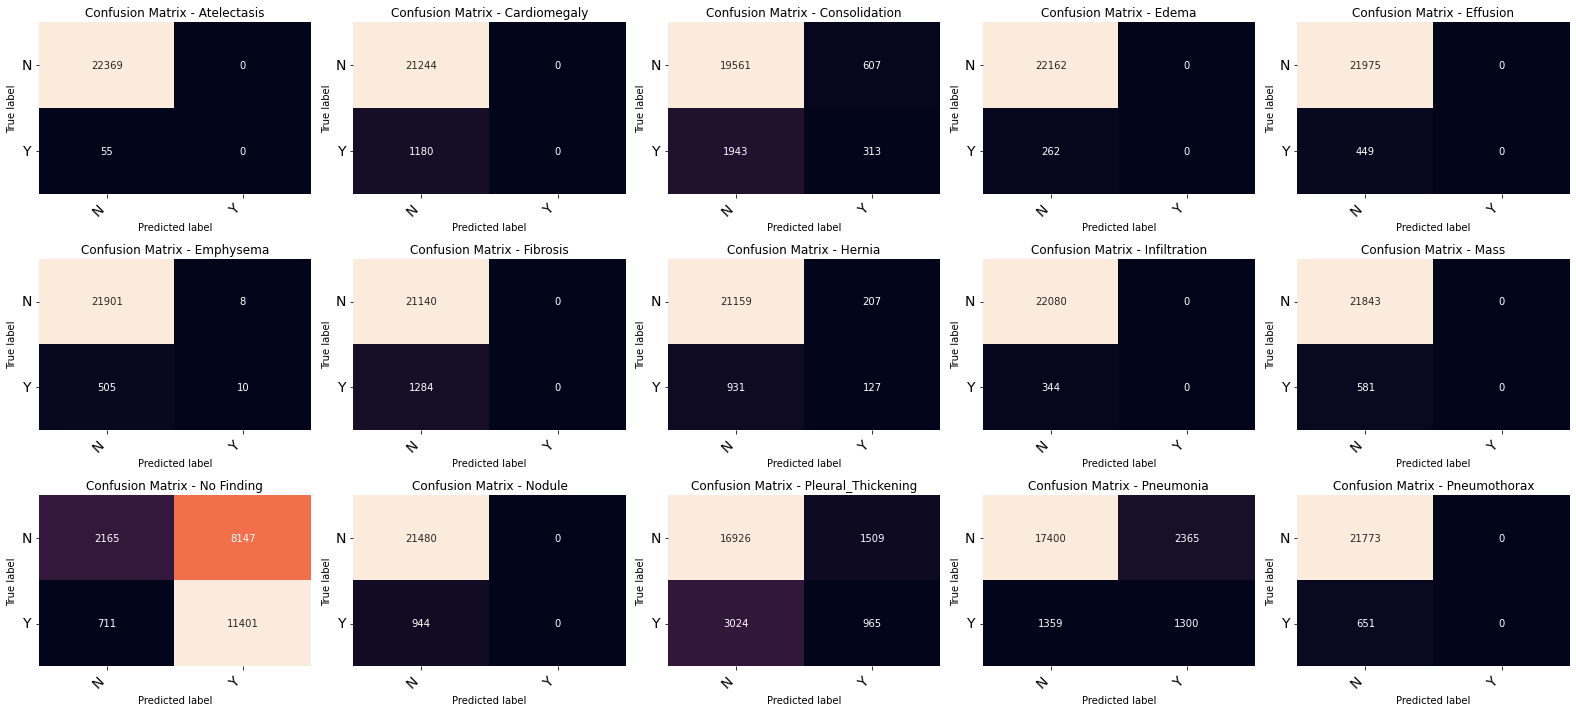

In [28]:
threshold = 0.3
y_test = test_gen.labels
y_predicted = (predictions >= threshold).astype(int)
confusion_matrix = multilabel_confusion_matrix(y_test, y_predicted)

fig, ax = plt.subplots(3, 5, figsize=(22, 10))
for axes, cfs_matrix, label in zip(ax.flatten(), confusion_matrix, CLASS_LABELS):
    print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
    
fig.tight_layout()
plt.show()

[MobileNet with 20 Epochs] - Average AUC: 0.7568523998435458


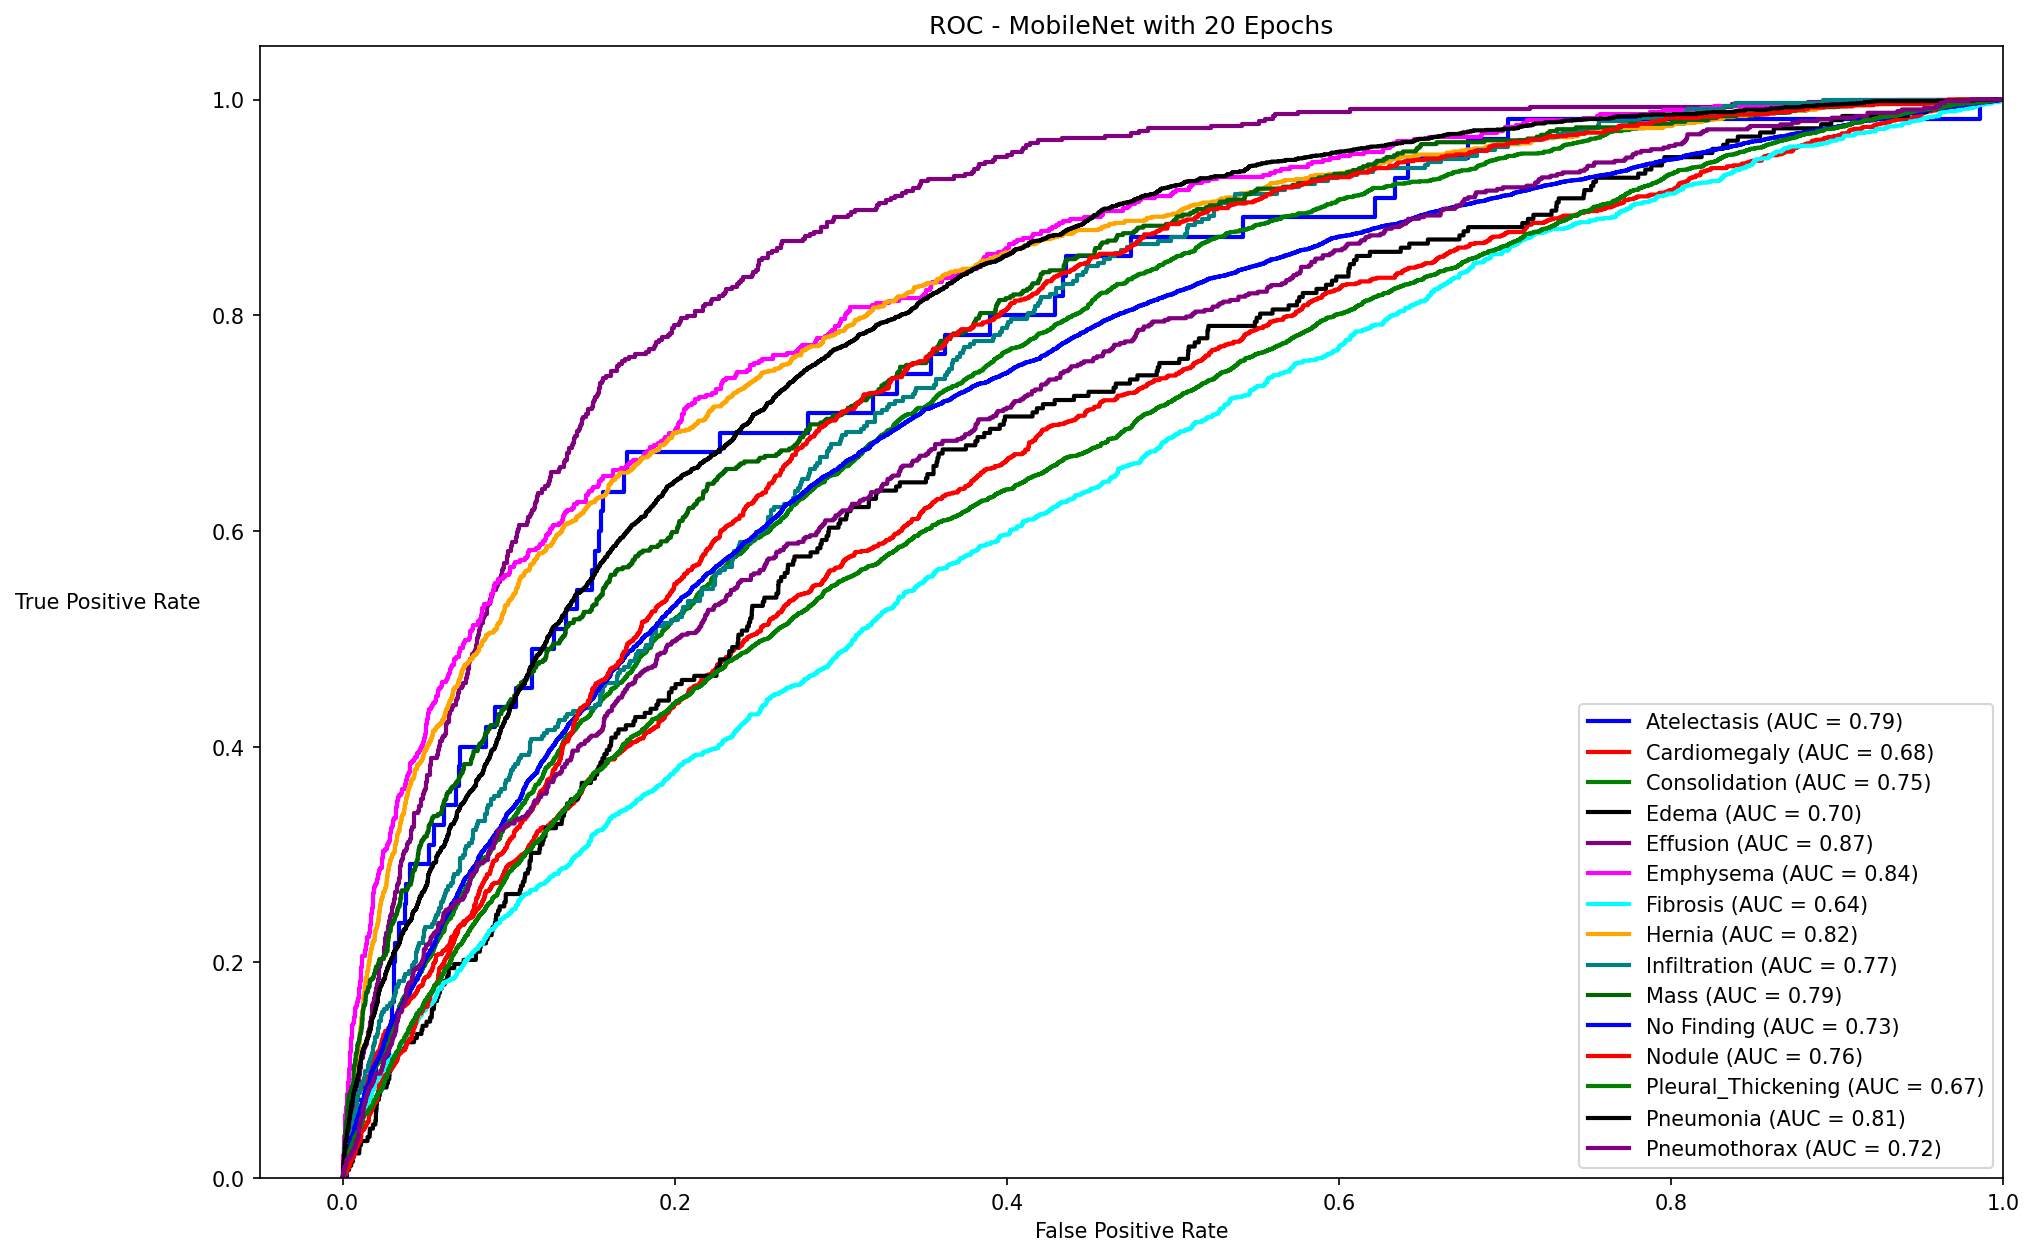

In [29]:
plt.rcParams["figure.figsize"] = (15,10)
plt.rcParams['figure.dpi'] = 150

colors = cycle(['blue', 'red', 'green', 'black', 'purple', 'magenta', 'cyan', 'orange', 'teal', 'darkgreen'])
fpr = dict()
tpr = dict()
roc_auc = dict()
lw = 2

for i in range(len(CLASS_LABELS)):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], predictions[:, i])
    roc_auc[i] = sklearn.metrics.auc(fpr[i], tpr[i])

avg_auc = 0
for auc_value in roc_auc.values():
    avg_auc += auc_value

print(f"[{MODEL_NAME} with {EPOCHS} Epochs] - Average AUC: {avg_auc / 15}")
    
for i, color in zip(range(len(CLASS_LABELS)), colors):
    plt.plot(fpr[i], tpr[i], color = color, lw = 2, label = '{0} (AUC = {1:0.2f})'''.format(CLASS_LABELS[i], roc_auc[i]))

plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate', rotation = 0, labelpad = 50)
plt.title(f'ROC - {MODEL_NAME} with {EPOCHS} Epochs')
plt.legend(loc = "lower right")
plt.show()